<div style="direction:rtl;line-height:300%;">
<font face="XB Zar" size=5>
<div align=center>
<font face="B Titr" size=5>
<p></p><p></p>
بسمه تعالی
<p></p>
</font>
<p></p>
<font>
<br>
درس بازیابی پیشرفته اطلاعات
<br>
مدرس: دکتر بیگی
</font>
<p></p>
<br>
<font>
<b>تمرین سوم</b>
</font>
<br>
<br>
موعد تحویل: ۴ دی <br>
<br>
<br>
<br>
<font>
دانشگاه صنعتی شریف
<br>
دانشکده مهندسی کامپیوتر
<br>
<br>
</font>
</div>
</font>
</div>

<span style="color: red;">
<div dir='rtl'>

<b> نام و نام‌‌خانوادگی: </b>
<!-- YOUR NAME HERE -->

<b> شماره دانشجویی: </b>
<!-- YOUR STUDENT ID HERE -->

<b> لینک colab: </b>

<!-- UPLOAD YOUR NOTEBOOK TO GOOGLE COLAB AND MAKE SURE TO RUN ALL OF ITS CELLS -->
</div>
</span>

<div dir='rtl'>
<h1> 
مقدمه
</h1>
<p>
در این تمرین قصد داریم به مباحث زیر بپردازیم:
<li> embedding </li>
<li> کلاسه‌بندی متن </li>
<li> کاهش ابعاد </li>
<li> خوشه‌بندی متن و هرس‌کردن خوشه‌ها</li>

دیتاست این تمرین از دیتاست‌های kaggle انتخاب شده‌است و لینک آن در بخش اول تمرین در اختیار شما قرار داده شده است.

کتابخانه‌های مورد نظرتان را هم می‌توانید در اولین سل نوت‌بوک فراخوانی کنید. 
</p>
</div>

In [2]:
import pandas as pd
import numpy as np
import string
import nltk
import torch
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.metrics import edit_distance
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import fasttext
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from typing import List

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/aliz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/aliz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<div dir='rtl'>
<h1>1.
دریافت و آماده‌سازی دیتاست
</h1>
<p>
دیتاست استفاده شده در این تمرین، مجموعه‌ای عناوین، خلاصه، و ژانر چندین کتاب است. 
این دیتاست در kaggle موجود است. 
ابتدا این دیتاست را با استفاده از kaggle api دریافت کنید و سپس آن را لود کنید.
<br/>
لینک دیتاست: https://www.kaggle.com/datasets/athu1105/book-genre-prediction
<br>
<i>در صورتی که با خطای 443 مواجه شدید، یا از پراکسی استفاده کنید یا از کولب.</i>
</p>
</div>

In [4]:
df = pd.read_csv('./data/phase-3/data.csv')

In [5]:
df.head()

,index,title,genre,summary
0,0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


<div dir='rtl'>
<p>
حال در این مرحله، به پیش‌پردازش متن می‌پردازیم. این پیش‌پردازش باید روی هر دو ستون title و summary اعمال شود.
برای پیش‌پردازش نیازی نیست که هرکدام از اعمال پیش‌پردازش را خودتان مانند تمارین قبل پیاده کنید. برای پیاده‌سازی تابع زیر می‌توانید از کتابخانه‌های معمول برای این کار بهره ببرید.
</p>
</div>

In [6]:
stopwords_domain = stopwords.words('english')

In [7]:
def preprocess_text(text, minimum_length=1, stopword_removal=True, stopwords_domain=stopwords_domain, lower_case=True,
                       punctuation_removal=True):
    """
    preprocess text by removing stopwords, punctuations, and converting to lowercase, and also filter based on a min length
    for stopwords use nltk.corpus.stopwords.words('english')
    for punctuations use string.punctuation

    Parameters
    ----------
    text: str
        text to be preprocessed
    minimum_length: int
        minimum length of the token
    stopword_removal: bool
        whether to remove stopwords
    stopwords_domain: list
        list of stopwords to be removed base on domain
    lower_case: bool
        whether to convert to lowercase
    punctuation_removal: bool
        whether to remove punctuations
    """

    normalized_tokens = word_tokenize(text)

    if stopword_removal:
        stopwords_domain = [x.lower() for x in stopwords_domain]
        normalized_tokens = [word for word in normalized_tokens if word.lower() not in stopwords_domain]

    if punctuation_removal:
        normalized_tokens = [word for word in normalized_tokens if word not in string.punctuation]

    if lower_case:
        normalized_tokens = [word.lower() for word in normalized_tokens if len(word) > minimum_length]

    else:
        normalized_tokens = [word for word in normalized_tokens if len(word) > minimum_length]

    return normalized_tokens



In [8]:
df["summary_preprocessed"] = df["summary"].apply(lambda x: preprocess_text(x))
df["title_preprocessed"] = df["title"].apply(lambda x: preprocess_text(x))

<div dir="rtl">
در نهایت بعد از اپلای کردن پیش‌پردازش روی هر دو ستون، دو ستون پیش‌پردازش شده را با هم ادغام کنید و آن را در یک آرایه به نام X قرار دهید.
</div>

In [9]:
X = df['title_preprocessed'] + df['summary_preprocessed']
X_text = [' '.join(x) for x in X]

In [10]:
X_text[1]

"lost hero book opens jason awakens school bus unable remember anything past sitting next piper mclean leo valdez call name say girlfriend best friend respectively three part class field trip grand canyon arrive classmate dylan turns venti storm spirit attacks trio trip leader coach gleeson hedge ensuing fight jason surprises everyone including one coins turns sword uses battle storm spirits coach hedge reveals satyr fight taken captive fleeing spirit battle flying chariot arrives rescue trio one people annabeth upset discovers missing boyfriend percy jackson expected annabeth seeking percy told vision goddess hera look `` guy one shoe '' turns jason shoe destroyed fight jason piper leo told demigods taken back camp half-blood meet greek demigod children like leo revealed son hephaestus piper daughter aphrodite jason son zeus though hera tells champion jason later discovers full brother zeus 's demigod daughter thalia grace hunter artemis shortly arrive three given quest rescue hera ca

<div dir="rtl">
<h2>1-1.
Embedding
</h2>

در این قسمت از fasttext کمک می‌گیریم تا به یک embedding اولیه برای هر کتاب برسیم.
    با استفاده از داده‌هایی که داریم یک مدل fasttext آموزش دهید که برای هر توکن یک امبدینگ ۱۰۰تایی بدهد.
    در مرحله‌ی بعد میانگین وزن دار امبدینگ های fasttext
        توکن‌های ورودی (چکیده + عنوان)
    را بر اساس tfidif آن‌ها محاسبه کنید و به امبدینگ نهایی متن برسید.
    <br>
    در واقع به عبارت ساده‌تر بر اساس میانگین وزن‌دار که وزن‌های ما tfidf توکن‌ها می‌باشد به امبدینگ نهایی متن بر اساس fasttext می‌رسیم.
</div>

In [11]:
class FastText:

    def __init__(self, preprocessor=None, method='skipgram'):
        self.method = method
        self.model = None
        self.preprocessor = preprocessor

    def train(self, texts):
        """
        train the fasttext model and save it into self.model
        Parameters
        ----------
        texts: list of list of str
        """
        file_name = './data/phase-3/data_cleaned.txt'
        with open(file_name, 'w') as f:
            for item in texts:
                f.write("%s\n" % item)
            f.close()

        self.model = fasttext.train_unsupervised(file_name, model=self.method)

    def get_query_embedding(self, query, tf_idf_vectorizer):
        """
        get the embedding of the query. You can use the tf_idf_vectorizer to get the weights of the words in the query. preprocess the query using self.preprocessor if it is not None
        Parameters
        ----------
        query: str
        tf_idf_vectorizer: TfidfVectorizer
        Returns embedding of the query
        """
        embedded_query = np.zeros(100)
        query = self.preprocessor(query)
        tf_idf_scores = tf_idf_vectorizer.transform([' '.join(query)]).toarray()
        for word in query:
            if word in tf_idf_vectorizer.vocabulary_.keys():
                word_indice = tf_idf_vectorizer.vocabulary_[word]
                embedded_query += tf_idf_scores[0][word_indice] * self.model.get_word_vector(word)

        return embedded_query

    def save_FastText_model(self, path='./models/FastText_model.bin'):
        self.model.save_model(path)

    def load_FastText_model(self, path="./models/FastText_model.bin"):
        self.model = fasttext.load_model(path)

    def prepare(self, dataset, mode, save=False):
        if mode == 'train':
            self.train(dataset)
        if mode == 'load':
            self.load_FastText_model()
        if save:
            self.save_FastText_model()

In [12]:
FastText_model = FastText(preprocessor=preprocess_text)
#FastText_model.prepare(X_text, mode='train', save=True)
FastText_model.prepare(X, mode='load')

In [13]:
word = "society"
FastText_model.model.get_nearest_neighbors(word)

[(0.8591963052749634, 'societies'),
 (0.8009070158004761, 'socialite'),
 (0.7904891967773438, 'popularity'),
 (0.7696753740310669, 'necessity'),
 (0.7695896625518799, 'sociology'),
 (0.7662913203239441, 'minority'),
 (0.7650023698806763, 'social'),
 (0.762621283531189, 'hostility'),
 (0.7590767741203308, 'somewhat'),
 (0.7529722452163696, 'variety')]

<div dir="rtl">
در این مرحله آرایه X را روی TFIDF فیت می‌کنیم.
</div>

In [14]:
class TF_IDF:

    def __init__(self):
        self.vectorizer = TfidfVectorizer()

    def fit_vectorizer(self, data):
        """
        fit the vectorizer on the data
        Parameters
        ----------
        data: list of list of str
        """
        self.vectorizer.fit_transform(data)

In [15]:
TF_IDF_model = TF_IDF()
TF_IDF_model.fit_vectorizer(X_text)

In [16]:
text = "society of the snow"
embedded_text = FastText_model.get_query_embedding(text, TF_IDF_model.vectorizer)
print(embedded_text)

[-7.17616975e-02  2.10961934e-01 -5.42877510e-01  3.40697616e-02
 -2.17942659e-01  4.01385922e-01 -3.85753706e-01  3.78655866e-02
  2.83031363e-01  2.67380588e-02  7.73399770e-02  7.13124871e-04
 -8.73379335e-02 -2.14429386e-01  1.75009078e-01 -2.44224072e-03
 -3.62448597e-01 -2.68902972e-01 -3.29792570e-01 -2.96907619e-01
 -2.85688328e-01  2.60224730e-01  5.93807891e-01 -7.79700339e-01
 -8.77694162e-02 -3.56491446e-01  6.57325327e-01 -1.51881497e-01
 -1.60567474e-01  4.16361041e-01  9.56058800e-02  3.83888096e-01
 -5.40342465e-01 -2.51021981e-02  1.01654902e-01  1.31682117e-01
 -3.33674386e-01 -1.56377517e-01 -2.16693155e-01  2.02762928e-01
 -2.27281950e-01  2.35352654e-01 -5.26909463e-01 -2.02047495e-01
 -2.10251696e-01 -3.49633917e-02  2.48428103e-01 -6.05616421e-02
 -8.59840214e-02  1.97307702e-01 -3.99786122e-01  2.05454738e-01
 -1.50714666e-01  1.82068817e-01  7.33831078e-02 -4.06116188e-01
 -1.22034255e-01  7.73363113e-02 -3.27639282e-02  4.00538981e-01
  2.06359334e-01  2.44054

<div dir="rtl">
در نهایت، تمامی entry های درون X را به صورت امبدینگ دربیاورید و آن را در X ذخیره کنید.
</div>

In [17]:
embeddings = []
for text in tqdm(X_text):
    embeddings.append(FastText_model.get_query_embedding(text, TF_IDF_model.vectorizer))

  1%|          | 29/4657 [00:00<01:08, 67.13it/s]

100%|██████████| 4657/4657 [01:14<00:00, 62.63it/s] 


<div dir='rtl'>
<h2>1-2. 
آماده‌سازی داده تمرین و تست
</h2>
<p>
در این بخش ابتدا می‌خواهیم تا داده‌ای که می‌خواهیم بر اساس آن کلاسه‌بندی کتاب‌ها را انجام دهیم، که همان ژانر کتاب‌ها است را انکود کنیم.
<br>
سپس با جداسازی داده آموزش و تست، به آموزش مدل‌های کلاسه‌بند می‌پردازیم.
</p>
</div>

In [18]:
labels = df['genre'].unique()
label_to_id = {}
id_to_label = {}
for i, label in enumerate(labels):
    label_to_id[label] = i
    id_to_label[i] = label

labels = df['genre'].apply(lambda x: label_to_id[x])

In [19]:
x_train, x_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2)
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

<div dir="rtl">
<h1>2. 
کلاسه‌بندی متن
</h1>
در این بخش می‌خواهیم تا با استفاده از داده‌هایی که داریم، سه مدل کلاسه‌بندی متن را آموزش دهیم و عملکرد آن‌ها را با هم مقایسه کنیم.
</div>

<div dir="rtl">
<h2>2-1. 
SVM و Naive Bayes
</h2>
با استفاده از توابع آماده در sklearn، کلاسه‌بند SVM و Naive Bayes را روی داده آموزش تمرین دهید. سپس، ژانر داده تست را با استفاده از مدل آموزش داده شده پیش‌بینی کنید و آن را در آرایه‌های NB_prediction و SVM_prediction ذخیره کنید.</div>

In [20]:
NB = GaussianNB()
NB.fit(x_train, y_train)

SVM = svm.SVC()
SVM.fit(x_train, y_train)


SVC()

In [21]:
NB_prediction = NB.predict(x_test)
SVM_prediction = SVM.predict(x_test)

<div dir="rtl">
<h2>2-2.  
Rocchio
</h2>
می‌خواهیم روش Rocchio را از
پایه پیاده‌سازی کنیم.
با توجه به شواهد نوشته شده هر تابع را کامل کنید و با آموزش مدل روی داده‌های train
لیبل‌های داده‌های test
را پیش بینی کنید و آن را در rocchio_prediction ذخیره کنید.
</div>

In [22]:
class RocchioTextClassifier:
    def __init__(self, preprocessor=None):
        self.preprocessor = preprocessor
        self.centroids = None

    def calculate_centroids(self, X, y):
        """
        Calculates the centroids of each class in the dataset. A centroid is defined as the mean vector of all the feature vectors in a class.

        Parameters
        ----------
        X : np.ndarray
            An array contaning the feature vectors of each sentence.

        y : np.ndarray
            An array containing the class labels for each feature vector in X.

        Sets self.centeroids as a dictionary where keys are unique class labels from 'y', and values are the calculated centroids (mean vectors) for each class.
        """
        self.centroids = {}
        for label in np.unique(y):
            self.centroids[label] = np.mean(X[y == label], axis=0)

    def predict_label(self, x):
        """
        Classifies a new instance by finding the class whose centroid is closest to the new instance's vector.

        Parameters
        ----------
        X : np.ndarray
            An array of a new instance to be classified.

        Returns
        -------
        object
            The predicted label for the input.
        """
        distances = []
        for centroid in self.centroids.values():
            distances.append(np.linalg.norm(x - centroid))
        return list(self.centroids.keys())[np.argmin(distances)]

    def predict(self, X):
        """
        Classifies the array X

        Parameters
        ----------
        X : np.ndarray
            An array of new instances to be classified.

        Returns
        -------
        object
            The predicted label for each input.
        """
        return np.array([self.predict_label(x) for x in X])


In [23]:
rocchio = RocchioTextClassifier()
rocchio.calculate_centroids(x_train, y_train)

In [24]:
Rocchio_prediction = rocchio.predict(x_test)

<div dir="rtl">
<h2>2-3. 
ارزیابی
</h2>
برای هر سه روش پیاده‌سازی شده، معیار‌های ارزیابی زیر را بررسی کنید.
<br>
f1 score, accuracy, precision, recall
<br>
سپس، نتایج به دست آمده را با هم در چهار نمودار مقایسه کنید.
</div>

In [25]:
SVM_accuracy = accuracy_score(y_test, SVM_prediction)
NB_accuracy = accuracy_score(y_test, NB_prediction)
Rocchio_accuracy = accuracy_score(y_test, Rocchio_prediction)

SVM_f1 = f1_score(y_test, SVM_prediction, average='macro')
NB_f1 = f1_score(y_test, NB_prediction, average='macro')
Rocchio_f1 = f1_score(y_test, Rocchio_prediction, average='macro')

SVM_recall = recall_score(y_test, SVM_prediction, average='macro')
NB_recall = recall_score(y_test, NB_prediction, average='macro')
Rocchio_recall = recall_score(y_test, Rocchio_prediction, average='macro')

SVM_precision = precision_score(y_test, SVM_prediction, average='macro')
NB_precision = precision_score(y_test, NB_prediction, average='macro')
Rocchio_precision = precision_score(y_test, Rocchio_prediction, average='macro')

/home/aliz/Desktop/personal/university/MIR/IR-project/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


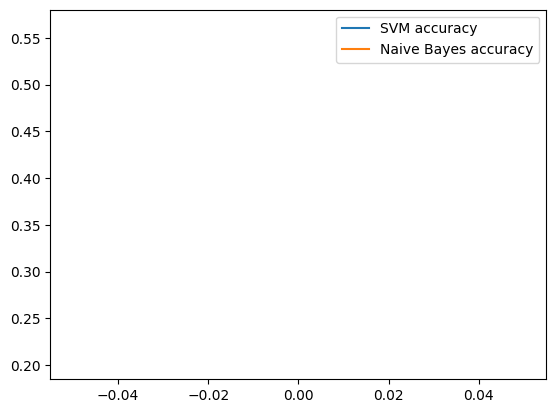

In [26]:
plt.plot(SVM_accuracy, label='SVM accuracy')
plt.plot(NB_accuracy, label='Naive Bayes accuracy')
plt.legend()
plt.show()

In [27]:
SVM_cm = confusion_matrix(y_test, SVM_prediction)
NB_cm = confusion_matrix(y_test, NB_prediction)
Rocchio_cm = confusion_matrix(y_test, Rocchio_prediction)

sns.heatmap(SVM_cm, annot=True, fmt='g', cmap='Reds', xticklabels=labels, yticklabels=labels)
sns.heatmap(NB_cm, annot=True, fmt='g', cmap='Reds', xticklabels=labels, yticklabels=labels)
sns.heatmap(Rocchio_cm, annot=True, fmt='g', cmap='Reds', xticklabels=labels, yticklabels=labels)



NameError: name 'sns' is not defined

<div dir="rtl">
کدام مدل از همه دقیق‌تر عمل کرد؟ نتیجه‌گیری و تحلیل خود از نتایج ارزیابی را گزارش دهید.
</div>

<span style="color: red;">#TODO: Write your answer in here.</span>


<div dir="rtl">
<h1>3. 
کاهش ابعاد و خوشه‌بندی متن
</h1>
</div>

<div dir="rtl">
<h2>3-1. 
کاهش ابعاد
</h2>
</div>

<div dir="rtl">
<h3>3-1-1. 
PCA
</h3>
یکی از روش‌های کاهش ابعاد، PCA است. با استفاده از پیاده‌سازی آن در کتابخانه sklearn، ابعاد ویژگی‌های X را کاهش دهید.
<br>
سپس با استفاده از explained_variance_ratio_ در الگوریتم PCA  نشان دهید که با وجود یک ترشولد 90 درصد تا چه میزان میتوان ابعاد ویژگی ها را کم تر کرد.
</div>

In [28]:
def reduce_dimension(embedding, n_components):
    """
    Performs dimensional reduction using PCA with n components left behind

    Parameters
    ----------
    embeddings : List
        A list of embeddings of documents

    n_components: int
        Number of components to keep

    Returns a list of reduced embeddings
    """
    pca = PCA(n_components=n_components)
    pca.fit(embedding)
    
    return pca.transform(embedding), pca.explained_variance_ratio_

<div dir="rtl">
در این قسمت می‌توانید برای شهود بهتر، نمودار رسم کنید و همچنین برای ساده‌تر شدن کار، از pipeline‌های sklearn بهره ببرید. 
<br>
<i> انجام این کار‌ها صرفا توصیه است و اجباری نیست. </i>
</div>

In [29]:
new_embeddings, variance_ratio = reduce_dimension(embeddings, 16)
print(variance_ratio)

[0.42830335 0.07977241 0.06723906 0.05688621 0.04332254 0.03011127
 0.02489885 0.02229607 0.01983365 0.01515618 0.014237   0.01259398
 0.01160499 0.01052717 0.01008627 0.00889603]


<div dir="rtl">
<h3>3-1-2. 
TSNE
</h3>
<br>
     برای اینکه بتوانید در مراحل بعدی، نتایج خوشه‌بندی را مشاهده کنید، در این قسمت به پیاده‌سازی تابع کاهش بعد بردارهای جاسازی با استفاده از روش T-SNE می‌پردازید.
برای اینکار تابع convert_to_2d_tsne را پیاده‌سازی می‌کنید که لیستی از بردارهای جاسازی را به عنوان ورودی دریافت می‌کند و در خروجی، لیستی از بردارهای جاسازی کاهش بعد داده شده به دو بعد را تولید می‌کند. برای پیاده سازی این تابع می‌توانید از کتابخانه‌های آماده استفاده کنید.
<br>
توجه کنید که از بردارهای خروجی این قسمت <u>صرفا برای رسم نمودار</u> استفاده می‌کنید و تمامی مراحلی که در ادامه طی می‌کنید (به جز رسم نمودار)، باید با استفاده از بردارهای کاهش بعد داده <u>نشده</u> انجام شوند.
</div>


In [30]:
from typing import List
from sklearn.manifold import TSNE
def convert_to_2d_tsne(emb_vecs):
    """
    Converts each raw embedding vector to 2d vector

    Parameters
    ----------
    emb_vecs : List
        A list of vectors

    Returns a list of 2d vectors
    """
    return TSNE(n_components=2).fit_transform(emb_vecs)

In [31]:
# TODO: Uncomment the following code
X_2d = convert_to_2d_tsne(np.array(X))

ValueError: setting an array element with a sequence.

<div dir="rtl">
<h2>3-2. 
خوشه‌بندی
</h2>
</div>

<div dir="rtl">
<h3>3-2-1. 
K-Means
</h3>

<div dir="rtl">
در این قسمت، شما ابتدا الگوریتم خوشه‌بندی K-means را 
<u><b>از پایه</b></u>
 پیاده‌سازی می‌کنید.

</div>

In [32]:
from typing import List
import random

def cluster_kmeans(emb_vecs, n_clusters):
    """
    Clusters input vectors using K-means method

    Parameters
    ----------
    emb_vecs : List
        A list of vectors

    n_clusters: int
        Number of clusters

    Returns
    -------
    list
        Two lists: 1) A list containing cluster centers 2) A list containing cluster index for each input vector
    """

    num_iter = 200

    # Randomly initialize centroids
    centroids = np.array(random.sample(list(emb_vecs), n_clusters))

    for _ in range(num_iter):
        distances = []
        for center in centroids:
            distances.append(np.linalg.norm(emb_vecs - center, axis=1))
        distances = np.array(distances)
        cluster_kmeans = np.argmin(distances, axis=0)
        for i in range(n_clusters):
            centroids[i] = np.mean(emb_vecs[cluster_kmeans == i], axis=0)
    
    return centroids.tolist(), cluster_kmeans.tolist()


<div dir="rtl">
 با استفاده از K-Means خوشه‌های اسناد را ایجاد کنید. الگوریتم را با استفاده از چند مقدار مختلف تعداد خوشه‌ها (k) اجرا کنید. در هربار اجرا، با استفاده از تعدادی از اسناد موجود در هر خوشه، موضوع آن خوشه را تعیین کرده و خوشه‌بندی حاصله را با استفاده از بردار‌های دوبعدی قسمت قبل، رسم کنید. با اینکار، پیاده‌سازی خود و همچنین کارایی این الگوریتم در خوشه‌بندی اسناد و قرار دادن اسناد مشابه در خوشه‌های یکسان را بررسی کنید.
<br>
 نمودار silhouette score برای مقدار‌های مختلف k را رسم کرده و silhouette analysis برای انتخاب k مناسب انجام دهید. 
 همچنین با استفاده از داده‌های دارای برچسب، مقدار purity به ازای k را رسم کرده و مقدار purity برای k نهایی را گزارش کنید.
<br>
</div>

In [33]:

def purity_score(y_true, y_pred):
    """
    Calculate the purity score for the given cluster assignments and ground truth classes

    y_true: list
        ground truth labels for each document

    y_pred: list
        predicted labels for each document

    Returns a purity score between 0.0 and 1.0 (higher is better)
    """
    cofusion_matrix = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(cofusion_matrix, axis=0)) / np.sum(cofusion_matrix)

In [ ]:
# TODO: Calculate silhouette score and purity score

In [ ]:
# TODO: Plot silhouette score for different value of k (at least 5 different k values)

In [ ]:
#TODO: plot purity for different value of k (at least 5 different k values)

<div dir="rtl">
با استفاده از نمودارهای رسم شده توضیح دهید بهترین k برای انتخاب در داده ما با استفاده از الگوریتم K-Means چیست؟
چرا؟
</div>

<span style="color: red;">#TODO: Write your answer in here.</span>

<div dir="rtl">
<h3>3-2-2. 
Hierarchical clustering
</h3>
</div>

<div dir="rtl">
تکنیک خوشه‌بندی سلسله مراتبی یکی از تکنیک‌های خوشه‌بندی در یادگیری ماشین است. در این قسمت شما می‌توانید از لایببری scipy یا هر لایبرری دیگری در پایتون استفاده کنید تا داده‌ها را به صورت سلسله‌مراتبی خوشه‌بندی کنید. سپس می‌توانید خوشه‌ها را با matplotlib مشاهده کنید.
</div>

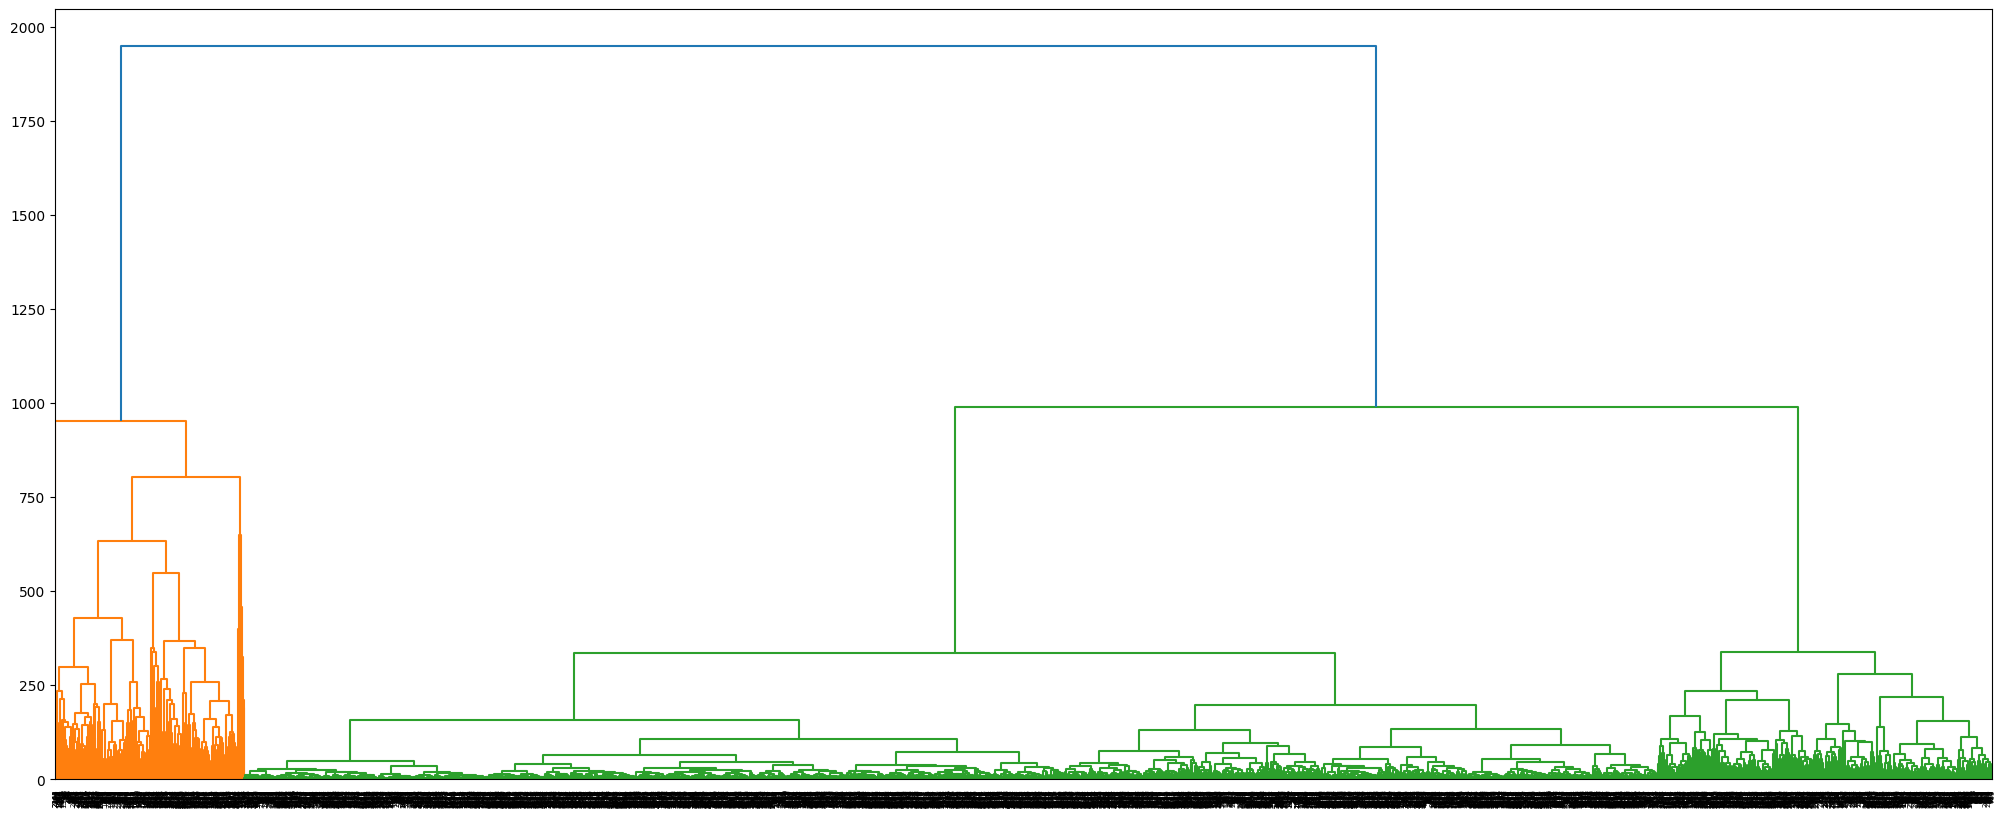

In [35]:
plt.figure(figsize=(25, 10))
HC = shc.dendrogram(shc.linkage(embeddings, method='ward'))